# Assignment 4: Annealing method applied for the 2D Thompson atomic model

The objective of this practice is to simulate a system composed of Coulomb charges in a two-dimensional trap (Thompson atomic model) by the classical Monte Carlo method and to use the annealing method to find the minimal energy configuration. The main steps to proceed are the following:

1. Write a Metropolis Monte Carlo code to simulate a system consisting of $N$ Coulomb charges in a two-dimensional harmonic trap. The energy of the configuration is given by

$$
    E_{pot} = \sum_{i=1}^{N}\frac{1}{2}m\omega^2r^2_i + \sum_{i<j}^{N}\frac{q^2}{|\vec{r}_i - \vec{r}_j|}
$$

We can choose a convenient combination of unitless units to simplify this expression into the dimensionless energy:

$$
    \tilde{E}_{pot} = \sum_{i=1}^N\hat{r}^2_i + \sum_{i<j}^N\frac{1}{|\hat{r}_i - \hat{r}_j|}
$$

2. From there we generate a random initial configuration. In my case, I will start with a normal distribution of the $N$ charges centered around the origin, with a standard deviation of $1$ in dimensionless units.
3. Use Metropolis algorithm to simulate system properties at a fixed temperature $\tilde{T}$, that is, to define the probability of a given configuration with the expression

$$
    p(\hat{r}) = e^{-\tilde{E}(\hat{r})/\tilde{T}}
$$

4. Use global moves (displace all particles at once) by randomly moving each coordinate $x' = x + \xi$ where $\xi$ is drawn from a Gaussian distribution $p(\xi) = \exp(-\frac{1}{2}\frac{\xi^2}{(\Delta t)^2})$ or $\xi = (2u - 1)\Delta t$ with $0 < u < 1$ being a uniformly distributed random variable.
5. Adjust the amplitude of the displacement $\Delta t$ in such a way that the acceptance probability lies between $(0.1,0.9)$.
6. Verify that after an initial transient regime, potential energy converges to a certain value and fluctuates around it.
7. Implement the annealing procedure in which the temperature is lowered by a tiny fraction at each iteration (e.g., $T := T\times0.999$), starting from a high temperature (compared to the typical system energy) and ending with a low temperature.
8. Repeat the annealing procedure a nubmer of times to verify that the optimal configuration has been found and in the case when different final configurations are realized, take the one which has the lowest energy.
9. Find and plot the optimal configurations for $N = 5, 20, 26$ charges.
10. Observe the structure of the global minimum. Look for shell structures, formation of Wigner crystals in the center, and state the type of lattice visible in the center region (square, hexagonal, etc.).
### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from tqdm import tqdm

### Class definition

In [2]:
class ThompsonAtom:
    def __init__(self,N):
        self.positions = np.random.randn(N,2)
        self.num_particles = N
        
    def energy(self,positions):
        n = self.num_particles
        harmonic_term = np.sum(np.linalg.norm(positions,axis=1)**2)
        coulomb_term = 0.0
        for i in range(n):
            for j in range(i+1,n):
                coulomb_term += 1/np.linalg.norm(positions[j]-positions[i])
        return harmonic_term + coulomb_term
    
    def simulatedAnnealing(self,N_iter=100,a=0.1,T0=100,cooldown=0.999):
        current_energy = self.energy(self.positions)
        best_energy = current_energy
        best_solution = dc(self.positions)
        
        # Save energies at each iteration
        self.energies = np.zeros(N_iter+1)
        self.energies[0] = current_energy
        
        # Keep track of acceptance rate
        accepted = 0
        
        T = T0
        for epoch in tqdm(range(N_iter)):
            # Generate new solution
            new_solution = self.positions + np.random.normal(scale=a, size=self.positions.shape)
            
            # Calculate difference in energies
            delta_energy = self.energy(new_solution) - current_energy
            
            # Accept new solution based on the acceptance probability (or its logarithm)
            if np.log(np.random.rand()) < -delta_energy/T:
                self.positions = new_solution
                current_energy += delta_energy
                accepted += 1
                
            # Keep track of best possible solution
            if current_energy < best_energy:
                best_energy = current_energy
                best_solution = dc(self.positions)
                
            # Cooldown
            T *= cooldown
            
            # Scale factor with temperature
            #a = np.sqrt(T)
            
            # Append energies
            self.energies[epoch+1] = current_energy
        
        # Acceptance rate
        print("Acceptance rate: ", accepted/N_iter)
        
        # Print energy per particle evolution
        iterations = np.arange(1,N_iter+2)
        
        plt.plot(iterations,self.energies/self.num_particles,color='red')
        plt.xlabel('Iteration')
        plt.ylabel(r'$E_{par}$')
        plt.show()
        
        # Print temperature evolution
        plt.plot(iterations,T0*cooldown**(iterations-1),color='blue')
        plt.xlabel('Iteration')
        plt.ylabel(r'$T$')
        plt.show()
        
        return best_energy, best_solution
    
    def printValues(self):
        # Print current energy
        print("Current energy (per particle) of the configuration is: ", self.energy(self.positions)/self.num_particles)
        
        # Plot current configuration
        plt.scatter(self.positions[:,0],self.positions[:,1],marker='o')
        plt.title("Thompson atom configuration")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel('X')
        plt.ylabel('Y')
        
        # Print the positive charge of the nucleus
        circle = plt.Circle((np.mean(self.positions[:, 0]), np.mean(self.positions[:, 1])), 
                    1.05*np.max(np.linalg.norm(self.positions - np.mean(self.positions, axis=0), axis=1)),
                    color='red', alpha=0.3)
        plt.gca().add_patch(circle)
        plt.show()

## First Part: Metropolis algorithm

In this first part we want the system to evolve from a transient regime, and observe the fluctuations around the final converged state for a given temperature.

Current energy (per particle) of the configuration is:  10.44408067818717


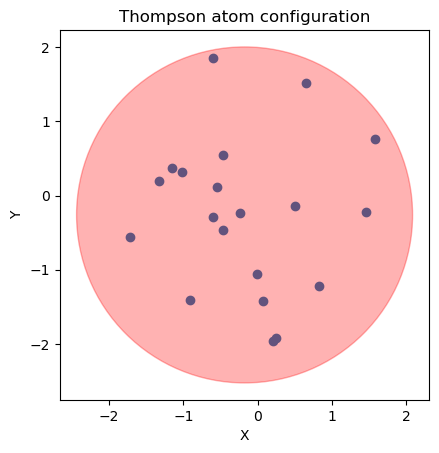

In [3]:
# For reproductibility purposes, we fix the randomness seed
np.random.seed(42)

# Initialize the system with N particles, and visualize it
N = 20
atom = ThompsonAtom(N)
atom.printValues()

We can observe that the system is disordered initially due to the randomness in its creation. For this reason, we expect the current energy to be higher than that of the ground state of the system. Now let us look at the evolution of the system at a certain temperature

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 836.25it/s]


Acceptance rate:  0.4587


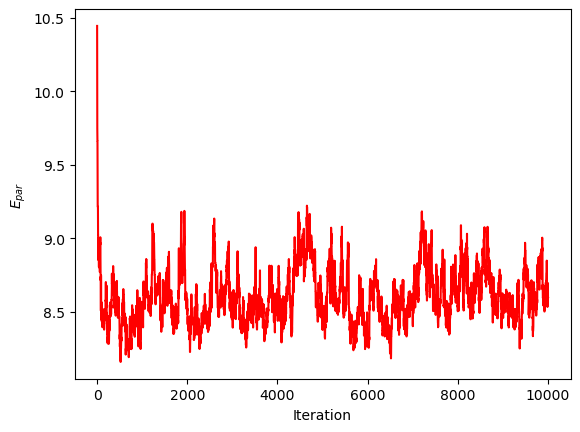

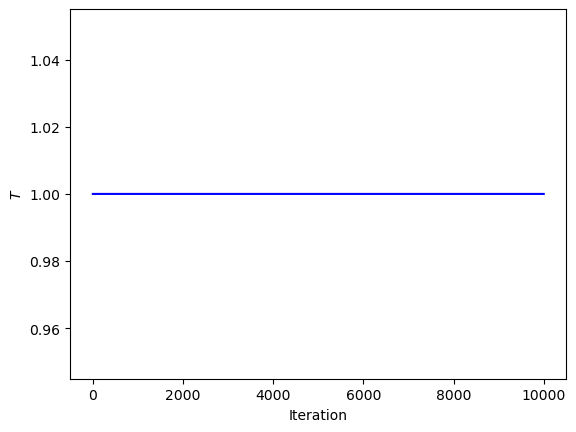

Current energy (per particle) of the configuration is:  8.593387343947986


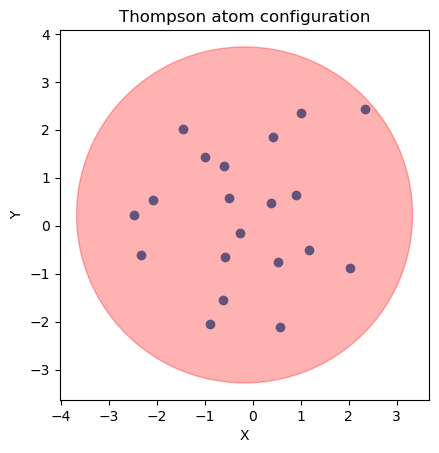

In [4]:
# Call simulated annealing with a cooldown rate of 1 (no cooldown) and fix the temperature
cooldown = 1
T0 = 1

# Let the system evolve and print the final configuration
energy, positions = atom.simulatedAnnealing(N_iter=10000,T0=T0,cooldown=cooldown)
atom.printValues()

Notice how after $\sim2000$ iterations, the energy per particle fluctuates around a value close to $8.75$ in which the charges keep moving around but never settle to an optimal configuration. Also the acceptance rate in this case is very high due to the temperature being a bit low compared to the energy of the system.

## Second Part: Simulated Annealing

In this second part, we are interested in finding the optimal configuration for which the energy of the system is minimum. For that, we will start with a high temperature value and reduce it after every iteration with the cooldown rate. 

### $N = 5$ charged particles

Current energy (per particle) of the configuration is:  4.164381485146121


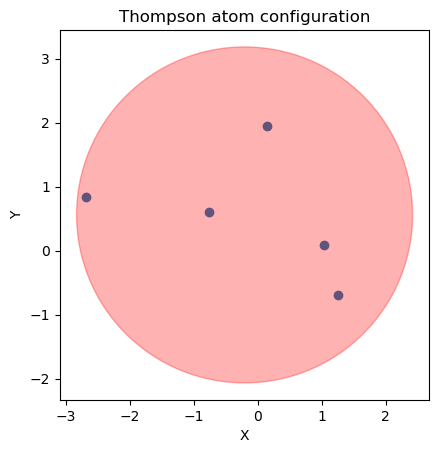

In [5]:
# Initialize the system with N particles, and visualize it
N = 5
atom = ThompsonAtom(N)
atom.printValues()

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 10388.36it/s]


Acceptance rate:  0.3883


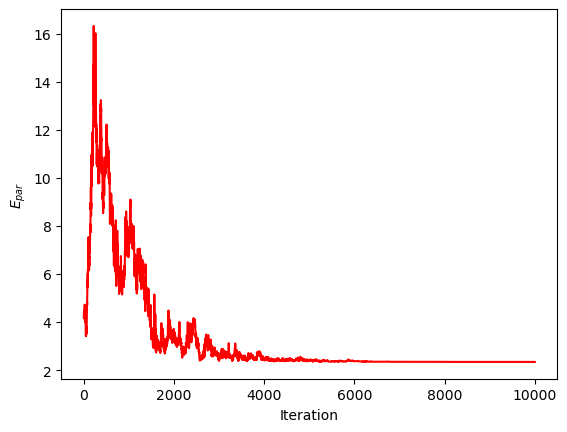

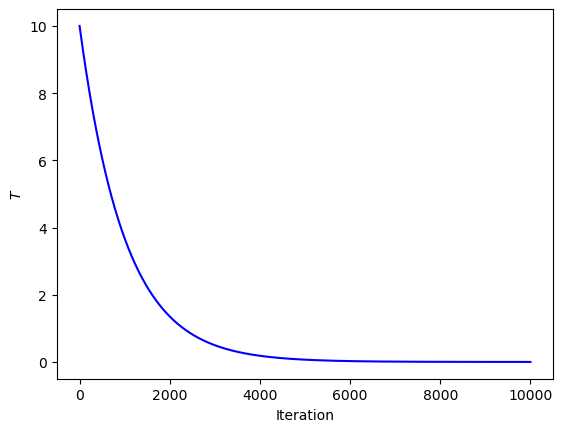

Current energy (per particle) of the configuration is:  2.341658181637496


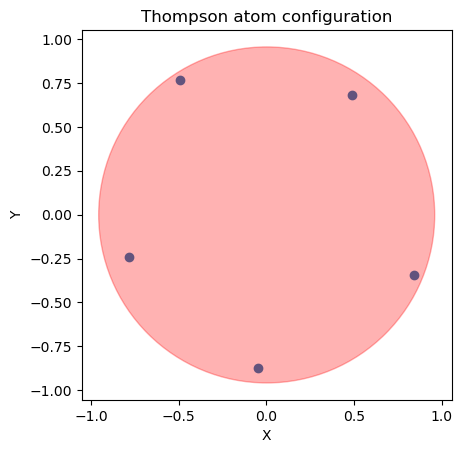

In [6]:
# Call simulated annealing with a fixed temperature
T0 = 10
cooldown = 0.999

# Let the system evolve and print the final configuration
energy, positions = atom.simulatedAnnealing(N_iter=10000,T0=T0,a=0.1,cooldown=cooldown)
atom.printValues()

In [7]:
# Calculate relative error with exact ground state energy
E0 = 2.33845 # Given in the pdf table
EN = energy/N # Energy per particle
print(f"The relative error is {np.abs(E0-EN)/E0*100}")

The relative error is 0.13719265485667997


Even with a very high initial temperature ($\sim2.5$ times the energy per particle of the initial configuration), the system converges to an optimal configuration, where the energy is minimal, and there is a single shell structure containing the $5$ charged particles similarly spaced.

### $N = 20$ charged particles

Current energy (per particle) of the configuration is:  10.873147438704256


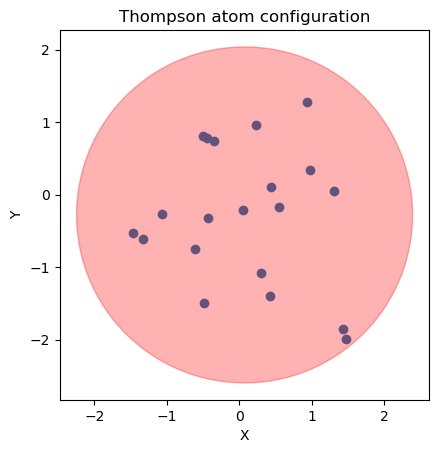

In [8]:
# Initialize the system with N particles, and visualize it
N = 20
atom = ThompsonAtom(N)
atom.printValues()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 885.21it/s]


Acceptance rate:  0.39515


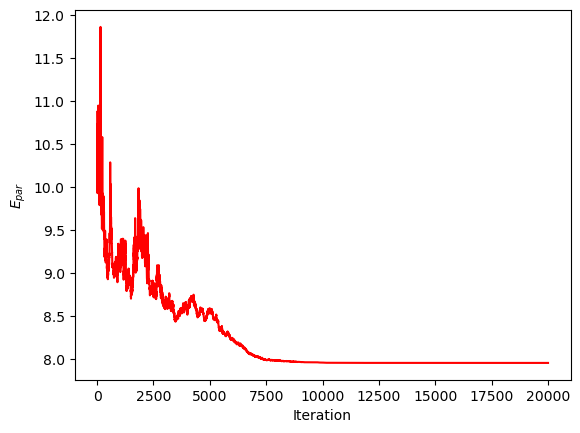

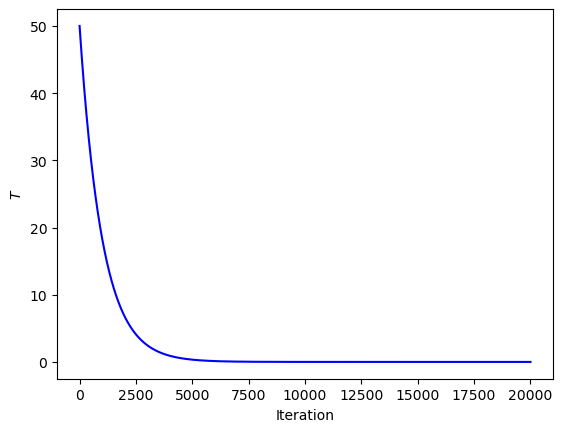

Current energy (per particle) of the configuration is:  7.950085845694417


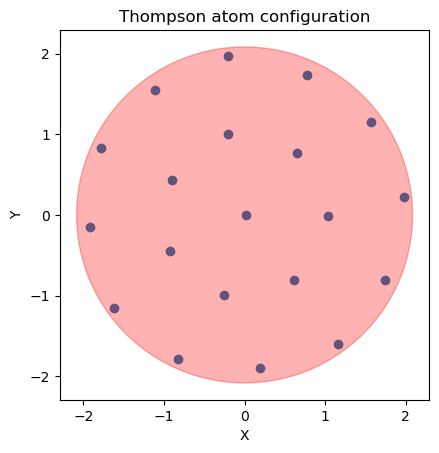

In [9]:
# Call simulated annealing with a fixed temperature
T0 = 50
cooldown = 0.999

# Let the system evolve and print the final configuration
energy, positions = atom.simulatedAnnealing(N_iter=20000,T0=T0,a=0.01,cooldown=cooldown)
atom.printValues()

In [10]:
# Calculate relative error with exact ground state energy
E0 = 7.94961 # Given in the pdf table
EN = energy/N # Energy per particle
print(f"The relative error is {np.abs(E0-EN)/E0*100}")

The relative error is 0.005985774074670169


In this case the ground state configuration shows 3 different shells with $N_1 = 1, N_2 = 7, N_3 = 12$ charged particles respectively. The actual ground state energy is $E/N = 7.94961$ which is within $0.005986\%$ of error.

### $N = 26$ charged particles

Current energy (per particle) of the configuration is:  12.390375576853163


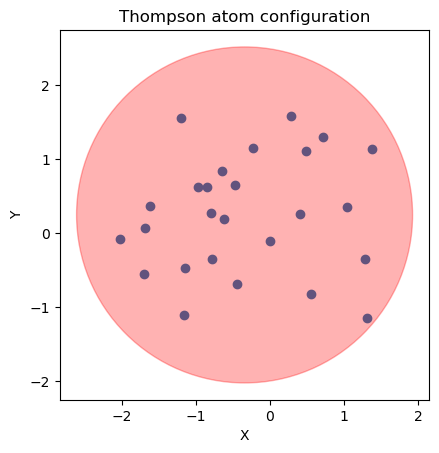

In [11]:
# Initialize the system with N particles, and visualize it
N = 26
atom = ThompsonAtom(N)
atom.printValues()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 508.18it/s]


Acceptance rate:  0.6384


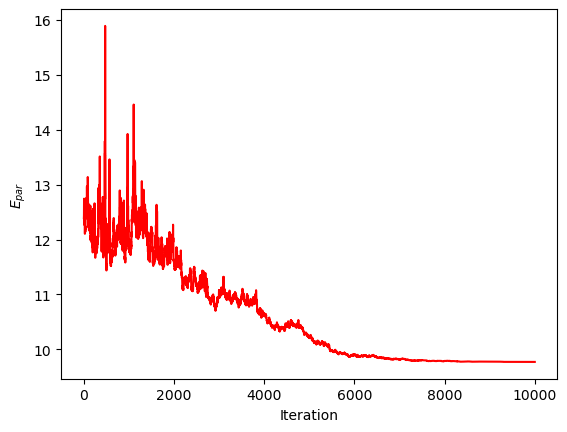

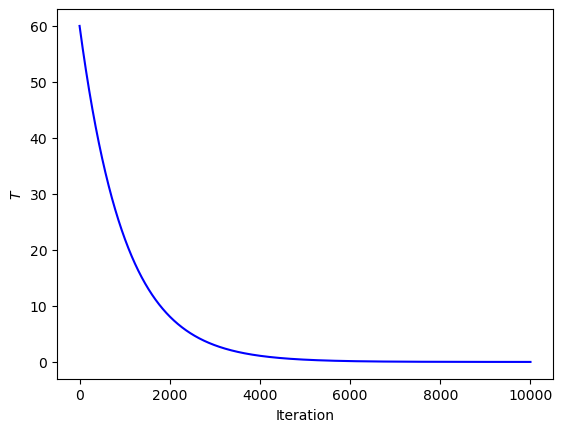

Current energy (per particle) of the configuration is:  9.771310165615924


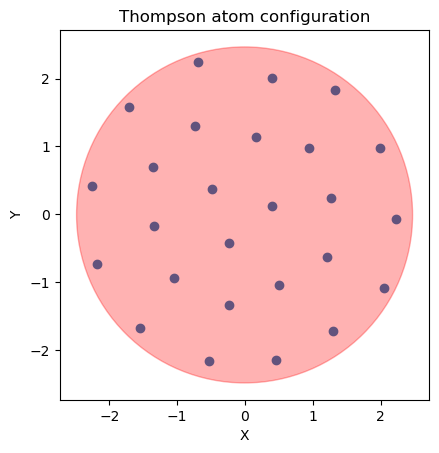

In [12]:
# Call simulated annealing with a fixed temperature
T0 = 60
cooldown = 0.999

# Let the system evolve and print the final configuration
energy, positions = atom.simulatedAnnealing(N_iter=10000,T0=T0,a=0.02,cooldown=cooldown)
atom.printValues()

In [13]:
# Calculate relative error with exact ground state energy
E0 = 9.76273 # Given in the pdf table
EN = energy/N # Energy per particle
print(f"The relative error is {np.abs(E0-EN)/E0*100}")

The relative error is 0.08691698850826658


The final configuration for the $N = 26$ case is achieved by filling the shells with $N_1 = 3, N_2 = 9, N_3 = 14$ charges respectively. In this case the relative error with the actual ground state energy is $0.08692\%$.